In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d

In [3]:
import sys
sys.path.append('/home/dallaert/tools/a2e-mmc/')

In [4]:
from mmctools.coupling.internal import SowfaInput
from mmctools.plotting import plot_timehistory_at_height, plot_profile
from mmctools.helper_functions import calc_wind, calc_uv

Define some physical constants

In [5]:
g  = 9.81            # Gravity [m s-2]
T0 = 300             # Reference temperature for perturbation temperature [K]
K  = 0.41            # von Karman constant
z0 = 0.1             # surface roughness length [m]

# Write Observational Data as SOWFA input files

## Load NNinterp observation data

Load natural neighbor interpolated observations dataset created within the notebook "process_TTU_radar.ipynb" which can be found in the [a2e-mmc/assessment repository](https://github.com/a2e-mmc/assessment)

In [6]:
all_data_NNinterp = 'TTU_obs_NNinterp_20131108.csv'

In [7]:
df = pd.read_csv(all_data_NNinterp,parse_dates=True,index_col='datetime')

In [8]:
# Calculate velocity components
df['u'],df['v'] = calc_uv(df)

In [11]:
df.head()

,height,wspd,wdir,u,v
datetime,,,,,
2013-11-08 12:00:00,0.0,1.225746,219.005685,0.771481,0.952507
2013-11-08 12:00:00,20.0,3.944645,239.036134,3.382502,2.029510
2013-11-08 12:00:00,40.0,7.112991,229.559781,5.413578,4.613872
2013-11-08 12:00:00,60.0,7.112991,229.559781,5.413578,4.613872
2013-11-08 12:00:00,80.0,11.136538,211.861594,5.878635,9.458548


## Load Amarillo sounding data

Load sounding data from Amarillo airport observation station (data downloaded from http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2013&MONTH=11&FROM=0800&TO=1000&STNM=72363)

In [12]:
datetime = '2013-11-08 12:00:00'
soundingdata = 'sounding.AMA/AMA_'+datetime.replace(' ','_')
ama_sounding = np.loadtxt(soundingdata,skiprows=8)

In [13]:
zsurface = 1099
knot_to_mpers = 0.514444

In [14]:
data = {}
data['height'] = ama_sounding[:,1]-zsurface
data['thetav'] = ama_sounding[:,10]
data['wspd'] = ama_sounding[:,7] * knot_to_mpers
data['wdir'] = ama_sounding[:,6]
ama = pd.DataFrame(data=data)
ama['datetime'] = pd.to_datetime(datetime)
ama.set_index(['datetime'],inplace=True)

In [15]:
ama.head()

,height,thetav,wspd,wdir
datetime,,,,
2013-11-08 12:00:00,0.0,287.4,8.745548,215.0
2013-11-08 12:00:00,54.0,288.9,10.288880,217.0
2013-11-08 12:00:00,267.0,295.1,16.462208,224.0
2013-11-08 12:00:00,343.0,296.2,18.519984,227.0
2013-11-08 12:00:00,425.0,298.4,21.092204,230.0


## Load TTU tower data

Load tower data for surface boundary conditions. The dataset is created within the notebook "process_TTU_tower.ipynb" which can be found in the [a2e-mmc/assessment repository](https://github.com/a2e-mmc/assessment)

In [16]:
towerdata = 'TTU_tilt_corrected_20131108-09_10min.csv'

In [17]:
tower = pd.read_csv(towerdata,parse_dates=True,index_col='datetime')

In [18]:
tower.head()

,height,RH,T,Ts,p,u,v,w,wspd,wdir,...,uu,vv,ww,uv,vw,uw,Tw,u*,TKE,TI
datetime,,,,,,,,,,,,,,,,,,,,,
2013-11-08,0.9,26.186,284.794,289.410000,908.547754,-0.138929,2.637817,0.074016,2.641473,176.985128,...,0.002408,0.015000,0.008343,0.0,0.0,0.0,0.0,0.0,0.012876,0.048531
2013-11-08,2.4,25.810,284.932,290.979994,908.723508,-0.601111,2.783204,0.487330,2.847378,167.812564,...,0.334290,0.165325,0.078520,0.0,0.0,0.0,0.0,0.0,0.289067,0.127188
2013-11-08,4.0,25.380,285.166,287.520000,908.215548,0.416792,4.043940,0.295800,4.065362,185.884463,...,0.009502,0.269958,0.003119,0.0,0.0,0.0,0.0,0.0,0.141290,0.119200
2013-11-08,10.1,25.264,285.298,287.250000,907.611414,-0.276479,5.227110,-0.418065,5.234417,176.972263,...,0.005414,0.027879,0.221537,0.0,0.0,0.0,0.0,0.0,0.127415,0.033082
2013-11-08,16.8,24.934,285.414,287.610000,907.307654,0.034364,5.908367,-0.173836,5.908467,180.333242,...,0.009586,0.054370,0.019302,0.0,0.0,0.0,0.0,0.0,0.041629,0.040458


Create DataFrame for first tower height and calculate suface skin potential temperature

In [19]:
tower1 = tower.loc[tower['height']==tower['height'].min()].copy()

In [20]:
tower1['L'] = -tower1['u*']**3 * tower1['theta'] / (K * g * tower1['Tw'])
tower1['zeta'] = tower1['height']/tower1['L']

In [21]:
#Monin-Obukhov similarity theory
betah = 5.0
gammah = 16.0

# Compute phi_h
tower1['phih'] = 0.0
tower1.loc[tower1['zeta']>=0.,'phih'] = 1 + betah * tower1.loc[tower1['zeta']>=0.,'zeta']
tower1.loc[tower1['zeta']<0.,'phih']  = (1 - gammah * tower1.loc[tower1['zeta']<0.,'zeta'])**(-0.5)

#Compute Psi_h
tower1['Psih'] = 0.0
tower1.loc[tower1['zeta']>=0.,'Psih'] = -betah * tower1.loc[tower1['zeta']>=0.,'zeta']
tower1.loc[tower1['zeta']<0.,'Psih']  = np.log( ( (1 + tower1.loc[tower1['zeta']<0.,'phih']**(-1.))/2. )**2. )

#Compute thetast
tower1['t*'] = -tower1['Tw']/tower1['u*']

#Compute thetaSK
tower1['thetaSK'] = tower1['theta'] - tower1['t*']/K* (np.log(tower1['height']/z0) - tower1['Psih'])

In [22]:
tower1.loc[tower1.index>='2013-11-08 12:00:00',['theta','Tw','thetaSK']].head()

,theta,Tw,thetaSK
datetime,,,
2013-11-08 12:00:00,281.165625,-0.007169,279.897038
2013-11-08 12:10:00,281.087986,-0.007809,280.180197
2013-11-08 12:20:00,281.132586,-0.006277,279.893052
2013-11-08 12:30:00,280.540031,-0.003653,280.029442
2013-11-08 12:40:00,279.779700,-0.004980,279.328486


## Write data as SOWFA input file

In [23]:
dateref = '2013-11-08 00:00:00'
datefrom = '2013-11-08 12:00:00'
dateto = '2013-11-09 12:00:00'

In [24]:
dirout = 'drivingData/obs/'

Use combined tower and radar data for timeheight profiles (vertical velocity and temperature are missing)

In [25]:
to_sowfa = SowfaInput(dirout,df,dateref,datefrom,dateto)
to_sowfa.write_timeheight('fieldTable',xmom='u',ymom='v',zmom='w',temp='thetav')
#Note: thetav does not exist so will be set to zero

Pivoting Dataset


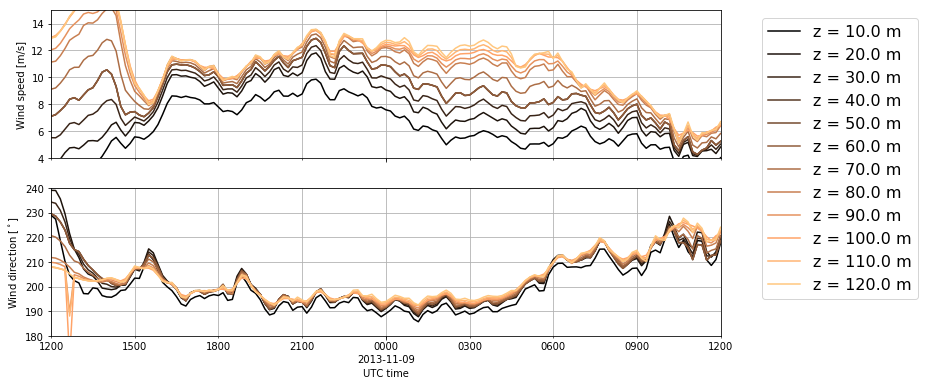

In [26]:
fig,ax = plot_timehistory_at_height(
    df,
    fields=['wspd','wdir'],
    heights=np.linspace(10,120,12),
    cmap='copper',
    timelimits=['2013-11-08 12:00','2013-11-09 12:00'],
    fieldlimits={'wspd':(4,15),'wdir':(180,240)}
)

Use Amarillo sounding to complement tower/radar data with temperature data

In [27]:
df_init = df.loc[datefrom].copy()
df_init['thetav'] = interp1d(ama['height'].values,ama['thetav'].values)(df_init.height)
df_init.head()

,height,wspd,wdir,u,v,thetav
datetime,,,,,,
2013-11-08 12:00:00,0.0,1.225746,219.005685,0.771481,0.952507,287.400000
2013-11-08 12:00:00,20.0,3.944645,239.036134,3.382502,2.029510,287.955556
2013-11-08 12:00:00,40.0,7.112991,229.559781,5.413578,4.613872,288.511111
2013-11-08 12:00:00,60.0,7.112991,229.559781,5.413578,4.613872,289.074648
2013-11-08 12:00:00,80.0,11.136538,211.861594,5.878635,9.458548,289.656808


In [28]:
to_sowfa = SowfaInput(dirout,df_init,dateref,datefrom,dateto)
to_sowfa.write_ICs('initialValues',xmom='u',ymom='v',temp='thetav')

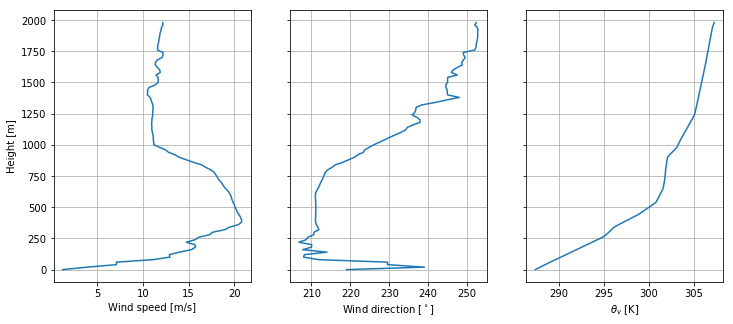

In [29]:
fig,ax = plot_profile(
    df_init,
    fields=['wspd','wdir','thetav'],
    times='2013-11-08 12:00',
    showlegend=False,
)

Use tower data for surface boundary conditions

In [30]:
to_sowfa = SowfaInput(dirout,tower1,dateref,datefrom,dateto)
to_sowfa.write_BCs('surfaceSkinPotentialTemperatureTable',fieldname='thetaSK')
to_sowfa.write_BCs('surfaceTemperatureFluxTable',fieldname='Tw',fact=-1.0)

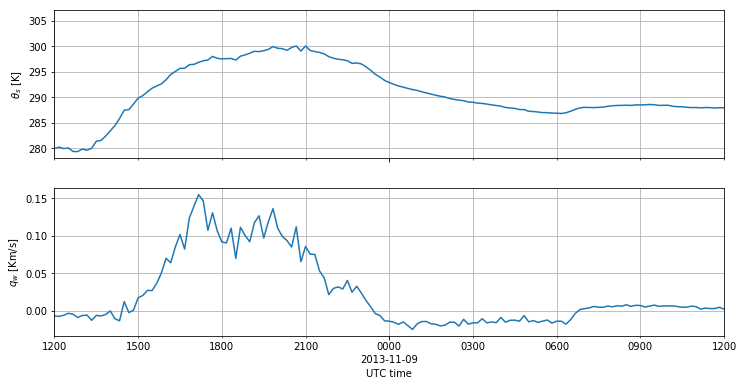

In [31]:
fig,ax = plot_timehistory_at_height(
    tower1,
    fields=['thetaSK','Tw'],
    heights=0.9,
    timelimits=['2013-11-08 12:00','2013-11-09 12:00'],
    fieldlabels={'thetaSK':r'$\theta_s$ [K]','Tw':r'$q_w$ [Km/s]'},
    showlegend=False,
)